In [1]:
import cupy as cp

In [2]:
class GRU:

    """
    GRU 神经网络
    """
    
    def __init__(self, input_size: int = None, hidden_size: int = None, output_size: int = None):

        """
        初始化 GRU 网络的权重矩阵和偏置向量

        Paramters
        ---------
        input_size : 输入维度
        hidden_size : 隐层状态维度
        output_size : 输出维度
        """

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.U_r = cp.random.normal(0, 1, (hidden_size, hidden_size))
        self.U_z = cp.random.normal(0, 1, (hidden_size, hidden_size))
        self.U_h = cp.random.normal(0, 1, (hidden_size, hidden_size))

        self.W_r = cp.random.normal(0, 1, (hidden_size, input_size))
        self.W_z = cp.random.normal(0, 1, (hidden_size, input_size))
        self.W_h = cp.random.normal(0, 1, (hidden_size, input_size))

        self.b_r = cp.random.randn(hidden_size)
        self.b_z = cp.random.randn(hidden_size)
        self.b_h = cp.random.randn(hidden_size)

        self.V = cp.random.randn(output_size, hidden_size)
        self.b_c = cp.random.randn(output_size)

    @ staticmethod
    def sigmoid(X: cp.ndarray = None) -> cp.ndarray:

        """
        sigmoid 激活函数

        Parameters
        ----------
        X : 特征数据集

        Returns
        -------
        value : 对特征数据进行非线性变换后的取值
        """
        
        value = 1 / (1 + cp.exp( - X))

        return value
    
    @ staticmethod
    def tanh(z: cp.ndarray = None) -> cp.ndarray:

        """
        tanh 激活函数

        Parameters
        ----------
        z : 净输入
        
        Returns
        -------
        y : 激活值
        """
        
        y = (cp.exp(z) - cp.exp( - z)) / (cp.exp(z) + cp.exp( - z))
        
        return y
    
    @ staticmethod
    def softmax(z: cp.ndarray = None, dim: int = 1) -> cp.ndarray:
        
        """
        softmax 函数

        Parameters
        ----------
        z : 净输入
        
        Returns
        -------
        y : 激活值
        """
        
        y = cp.exp(z) / cp.expand_dims(cp.sum(cp.exp(z), axis = dim), axis = -1)
        
        return y
    
    # 单个 GRU 单元
    def GRU_cell(self, x: cp.ndarray = None, h: cp.ndarray = None) -> tuple[cp.ndarray, tuple[cp.ndarray, cp.ndarray], cp.ndarray, cp.ndarray]:

        """
        GRU 单元，将 t 时刻的输入 x 和 t-1 时刻的隐层状态输出 h 转换为 t 时刻的预测值 y_hat 和隐层状态输出 h_wave、h

        Paramters
        ---------
        x : 输入张量，形状为 [batch_size, 1, input_size]
        h : 前一时刻的隐层状态，形状为 [batch_size, 1, hidden_size]

        Returns
        -------
        y_hat : GRU 单元当前时刻的预测值，形状为 [batch_size, output_size]
        r : 当前时刻的重置门，形状为 [batch_size, hidden_size]
        z : 当前时刻的更新门，形状为 [batch_size, hidden_size]
        h_wave : 当前时刻的 h_wave ，形状为 [batch_size, hidden_size]
        h : 当前时刻的隐层状态输出，形状为 [batch_size, 1, hidden_size]
        """
        
        r = self.sigmoid(cp.sum(self.U_r * h, axis = -1) + cp.sum(self.W_r * x, axis = -1) + self.b_r)
        z = self.sigmoid(cp.sum(self.U_z * h, axis = -1) + cp.sum(self.W_z * x, axis = -1) + self.b_z)
        h_wave = self.tanh(cp.sum(self.U_h * cp.expand_dims(r * h.squeeze(1), axis = 1), axis = -1) + cp.sum(self.W_h * x, axis = -1) + self.b_h)

        h = (1 - z) * h_wave + z * h.squeeze(1)
        h = cp.expand_dims(h, axis = 1)
        c = cp.sum(self.V * h, axis = -1) + self.b_c

        yt_hat = self.softmax(c, dim = 1)
        return yt_hat, (r, z), h_wave, h

    def forward(self, X: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray, cp.ndarray]:

        """
        前向传播计算预测值

        Paramters
        ---------
        X : 输入张量，形状为 [time_steps, batch_size, input_size]

        Returns
        -------
        y_hat : 全部时刻的预测值，形状为 [batch_size, output_size]
        total_c : 全部时刻的细胞状态，形状为 [batch_size, hidden_size]
        total_h : 全部时刻的隐层状态，形状为 [batch_size, hidden_size]
        """

        batch_size = X.shape[1]

        y_hat = []

        h = cp.zeros((batch_size, 1, self.hidden_size))

        self.r = []
        self.z = []
        self.h_wave = []

        total_h = []
        
        for t in range(len(X)):
            
            x = cp.expand_dims(X[t], axis = 1)
            yt_hat, (r, z), h_wave, h = self.GRU_cell(x, h)

            self.r.append(cp.expand_dims(r, axis = 0))
            self.z.append(cp.expand_dims(z, axis = 0))
            self.h_wave.append(cp.expand_dims(h_wave, axis = 0))

            total_h.append(cp.expand_dims(h.squeeze(1), axis = 0))
            y_hat.append(cp.expand_dims(yt_hat, axis = 0))
        
        self.r = cp.vstack(self.r)
        self.z = cp.vstack(self.z)
        self.h_wave = cp.vstack(self.h_wave)

        total_h = cp.vstack(total_h)
        y_hat = cp.vstack(y_hat)

        return y_hat, total_h
    
    def backward(self, X: cp.ndarray = None, y: cp.ndarray = None, lr: float = 0.01):

        """
        反向传播计算梯度

        Paramters
        ---------
        X : 输入张量，形状为 [time_steps, batch_size, input_size]
        y : 输入张量，形状为 [time_steps, output_size]
        lr : 学习率
        """

        time_steps = len(X)
        batch_size = X.shape[1]

        y_hat, total_h = self.forward(X)

        X = cp.expand_dims(X, axis = 2)
        
        delta = cp.sum(self.V.T * cp.expand_dims(y_hat[-1] - y[-1], axis = 1), axis = -1)

        r = self.r[-1]
        z = self.z[-1]
        h_wave = self.h_wave[-1]
        
        h = cp.expand_dims(total_h[-2], axis = 1)
        x = X[-1]

        L_part = delta * (1 - z) * (1 - h_wave * h_wave)
        L = cp.sum(self.U_h.T * cp.expand_dims(L_part, axis = 1), axis = -1) * h.squeeze(1) * r * (1 - r)
        L_Ur = L.reshape(batch_size, self.hidden_size, 1) @ h
        L_Wr = L.reshape(batch_size, self.hidden_size, 1) @ x
        L_br = L
        
        L = delta * z * (1 - z) * (h.squeeze(1) - h_wave)
        L_Uz = L.reshape(batch_size, self.hidden_size, 1) @ h
        L_Wz = L.reshape(batch_size, self.hidden_size, 1) @ x
        L_bz = L

        L_Uh = L_part.reshape(batch_size, self.hidden_size, 1) @ cp.expand_dims(r * h.squeeze(1), axis = 1)
        L_Wh = L_part.reshape(batch_size, self.hidden_size, 1) @ x
        L_bh = L_part
        
        L = y_hat[-1] - y[-1]
        L_V = L.reshape(batch_size, self.output_size, 1) @ cp.expand_dims(total_h[-1], axis = 1)
        L_bc = L

        for t in range(time_steps - 1, 0, -1):

            r = self.r[t]
            z = self.z[t]
            h_wave = self.h_wave[t]

            h = total_h[t - 1]
            x = X[t - 1]
            
            p1 = cp.sum(self.V.T * cp.expand_dims((y_hat[t - 1] - y[t - 1]), axis = 1), axis = -1)
            p2 = L_part * cp.sum(self.U_h * cp.expand_dims(r, axis = 1), axis = -1)
            p3 = delta * z
            p4 = cp.sum(self.U_z.T * cp.expand_dims(delta, axis = 1), axis = -1) * (h - h_wave) * z * (1 - z)
            
            delta = p1 + p2 + p3 + p4

            r = self.r[t - 1]
            z = self.z[t - 1]

            h_wave = self.h_wave[t - 1]
            
            L_part = delta * (1 - z) * (1 - h_wave * h_wave)

            if t > 1:
                
                h = cp.expand_dims(total_h[t - 2], axis = 1)
                
                L = cp.sum(self.U_h.T * cp.expand_dims(L_part, axis = 1), axis = -1) * h.squeeze(1) * r * (1 - r)
                L_Ur_t = L.reshape(batch_size, self.hidden_size, 1) @ h
                L_Ur += L_Ur_t

                L_Wr_t = L.reshape(batch_size, self.hidden_size, 1) @ x
                L_Wr += L_Wr_t

                L_br_t = L
                L_br += L_br_t
            
                L = delta * z * (1 - z) * (h.squeeze(1) - h_wave)
                L_Uz_t = L.reshape(batch_size, self.hidden_size, 1) @ h
                L_Uz += L_Uz_t

                L_Wz_t = L.reshape(batch_size, self.hidden_size, 1) @ x
                L_Wz += L_Wz_t

                L_bz_t = L
                L_bz += L_bz_t
            
                L_Uh_t = L_part.reshape(batch_size, self.hidden_size, 1) @ cp.expand_dims(r * h.squeeze(1), axis = 1)
                L_Uh += L_Uh_t

            L_Wh_t = L_part.reshape(batch_size, self.hidden_size, 1) @ x
            L_Wh += L_Wh_t

            L_bh_t = L_part
            L_bh += L_bh_t
            
            L = y_hat[t - 1] - y[t - 1]
            L_V_t = L.reshape(batch_size, self.output_size, 1) @ cp.expand_dims(total_h[t - 1], axis = 1)
            L_V += L_V_t
            L_bc_t = L
            L_bc += L_bc_t

        L_Ur = cp.mean(L_Ur, axis = 0)
        L_Wr = cp.mean(L_Wr, axis = 0)
        L_br = cp.mean(L_br, axis = 0)

        L_Uz = cp.mean(L_Uz, axis = 0)
        L_Wz = cp.mean(L_Wz, axis = 0)
        L_bz = cp.mean(L_bz, axis = 0)

        L_Uh = cp.mean(L_Uh, axis = 0)
        L_Wh = cp.mean(L_Wh, axis = 0)
        L_bh = cp.mean(L_bh, axis = 0)

        L_V = cp.mean(L_V, axis = 0)
        L_bc = cp.mean(L_bc, axis = 0)

        self.U_r -= lr * L_Ur
        self.U_z -= lr * L_Uz
        self.U_h -= lr * L_Uh

        self.W_r -= lr * L_Wr
        self.W_z -= lr * L_Wz
        self.W_h -= lr * L_Wh
        
        self.b_r -= lr * L_br
        self.b_z -= lr * L_bz
        self.b_h -= lr * L_bh

        self.V -= lr * L_V
        self.b_c -= lr * L_bc

In [3]:
sen = """我愿变成一颗恒星，守护海底的蜂鸣。It's my dream, it's magic，照亮你的心。To your eyes，有多远的距离？穿过人海，别停下来，趁现在还有期待。会不会我们的爱，会被风吹向大海，不再回来？每当你向我走来，告诉我星辰大海。遥遥微光，与我同行，盛开在黎明。To your eyes，有多远的距离？穿过人海，别停下来，趁现在还有期待。会不会我们的爱，会被风吹向大海，不再回来？每当你向我走来，告诉我星辰大海。趁现在还有期待，会不会我们的爱，会被风吹向大海，不再回来？每当你向我走来，告诉我星辰大海。会不会我们的爱，像星辰守护大海，不曾离开？我向你奔赴而来，你就是星辰大海。我眼中炽热的恒星，长夜里照我前行。"""

In [4]:
import jieba
vocabs = [vocab for vocab in jieba.cut(sen)]
vocabs = ["<begin>", "《星辰大海》", "歌手：黄霄云"] + vocabs + ["<end>"]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIANGX~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.380 seconds.
Prefix dict has been built successfully.


In [5]:
import numpy as np
word = np.unique(vocabs)
word_dict = {}
vocab_dict = {}
for i in range(len(word)):
    emb = [0] * len(word)
    emb[i] = 1
    word_dict[word[i]] = emb
    vocab_dict[i] = word[i]
input_size = len(word)
hidden_size = 8
output_size = len(word)
X = cp.array([[word_dict[vocab]] for vocab in vocabs[:-1]])
y = cp.array([[word_dict[vocab]] for vocab in vocabs[1:]])

In [6]:
# 实例化 GRU 循环神经网络
gru = GRU(input_size, hidden_size, output_size)

In [7]:
# 定义评估函数
def eval(y: cp.ndarray = None, y_hat: cp.ndarray = None) -> cp.ndarray:
        
    """
    评估模型表现

    Parameters
    ----------
    y : 真实标签
    y_hat : 预测标签

    Returns
    -------
    loss : 交叉熵损失值
    """
    
    # loss 为标量，将单个样本每个类别、每个时刻的损失累加在一起得到单个样本的交叉熵损失，最后对所有样本的损失求平均
    ## y * cp.log(y_hat) 形状为 [time_step, batch_size, output_size]
    ## cp.sum(y * cp.log(y_hat), axis = -1) 形状为 [time_step, batch_size]
    ## cp.sum(cp.sum(y * cp.log(y_hat), axis = -1), axis = 0) 形状为 batch_size
    loss = - cp.sum(cp.sum(y * cp.log(y_hat), axis = -1), axis = 0)
    loss = cp.mean(loss).item()

    return loss

In [8]:
train_loss = []
# 训练 500 次
for i in range(500):
    
    # 反向传播更新参数
    gru.backward(X, y, lr = 0.01)
    # 前向传播评估算法表现
    y_hat, h = gru.forward(X)
    # 评估本次更新参数后的算法表现
    loss = eval(y, y_hat)
    print(loss)
    train_loss.append(loss)

1288.908682301656
1135.057274978919
1066.8664116325904
1005.504663123361
972.2873150891257
941.5479062602456
917.4244600863286
890.3773707647132
874.0868415827582
855.5949750889597
840.6540849845467
825.5229213831099
807.3511091314942
791.3687211456829
778.4606169001133
766.733115697755
755.9030505563494
745.9044869036823
736.4927222873123
727.6726874559671
719.3486210604568
711.6245135224613
704.4420878469259
697.8629411927116
692.1120884026157
686.6210045567552
686.376339938356
689.265408427656
687.9329259705046
665.6982219186567
654.831445843527
649.8641836137118
644.045267475571
639.7330862707837
637.2328942115728
630.1836266815064
623.7630408362903
616.360632602645
609.9465103602946
602.7975806486853
597.5640372488524
590.5219943516458
585.6507567379338
579.0138537101923
574.2526860899848
568.0444190353239
563.335099683117
557.5137659253171
552.8656700361762
547.3616027657151
542.7795919219897
537.5145401194216
532.9832394127858
527.8887751037282
523.3807662335046
518.408427524420

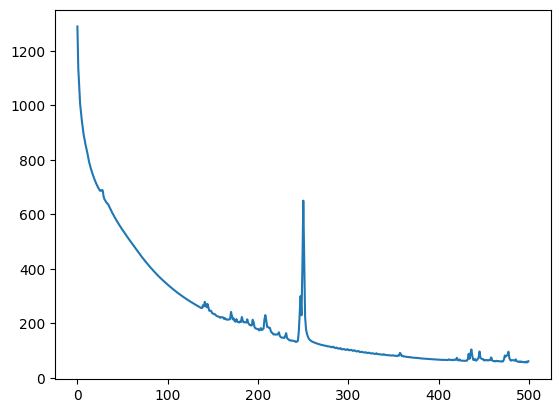

In [9]:
# 损失函数下降情况
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [10]:
import time

# GRU 背诵歌词
h = cp.zeros((1, 1, hidden_size))
for i in range(X.shape[0]):
    
    yt_hat, (r, z), h_wave, h = gru.GRU_cell(cp.expand_dims(X[i], axis = 1), h)
    if list(word_dict.keys())[cp.argmax(yt_hat.squeeze(0), axis = -1).item()] == "<end>":
        break
    print(list(word_dict.keys())[cp.argmax(yt_hat.squeeze(0), axis = -1).item()])
    time.sleep(0.5)

《星辰大海》
歌手：黄霄云
我愿
变成
一颗
恒星
，
守护
海底
的
蜂鸣
。
It
'
s
 
my
 
dream
,
 
it
'
s
 
magic
，
照亮
你
的
心
。
To
 
your
 
eyes
，
有多远
的
距离
？
穿过
人
海
，
别
停下来
，
趁现在
还有
期待
。
会
不会
我们
的
爱
，
会
被
风吹
向
大海
，
不再
回来
？
每当
你
向
我
走来
，
告诉
我
星辰
大海
。
会
微光
，
与
我
同行
，
盛开
在
黎明
。
To
 
your
 
eyes
，
有多远
的
距离
？
穿过
人
海
，
别
停下来
，
趁现在
还有
期待
。
会
不会
我们
的
爱
，
会
被
风吹
向
大海
，
不再
回来
？
每当
你
向
我
走来
，
告诉
我
星辰
大海
。
会
还有
期待
。
会
不会
我们
的
爱
，
会
被
风吹
向
大海
，
不再
回来
？
每当
你
向
我
走来
，
告诉
我
星辰
大海
。
会
不会
我们
的
爱
，
会
星辰
守护
大海
，
你
离开
？
我
向
你
奔赴
而
来
，
你
就是
星辰
大海
。
我
眼中
炽热
的
恒星
，
长
夜里
照
我
前行
。
